# Human Activity Clustering
### Umar Faruk Abdullahi (faruk.abdullahi@abo.fi)

### Project Description:
In this project, we train machine learning models for sentiment analysis using the Twitter Sentiment140 dataset. We train the two models to correctly classify tweets as either positive or negative.

The project is separated into four steps:


*   Data Processing and EDA
*   Feature Selection and Engineering
*   Model Training and Evaluation
*   Model Comparison




## Imports

We load all the relevant data science and machine learning libraries required for the execution of the project.

Also, we import utility libraries to aid in our data fetching.

Data is loaded from a remote location if not present in the current runtime.

In [ ]:
!pip install kneed

In [ ]:
import os
import requests
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from kneed import KneeLocator

## Data Loading and Pre-processing

The data provided contains numerous sub-data file splits. To facilitate our project, we load the initial data as provided and process it into a unified dataframe for usage.

The generated processed files are also stored in a remote location and used for the rest of the project.

Refer to this cell for usage: [Pre-processed Data](#scrollTo=Ub3jGQLL6M4I&line=3&uniqifier=1)

**NB: THE CELLS BELOW WILL LIKELY FAIL IF THE CORRESPONDING FILES ARE NOT IN THE DIRECTORY, PLEASE REFER TO THE [NEXT SECTION](#scrollTo=Ub3jGQLL6M4I&line=3&uniqifier=1) TO LOAD PRE-PROCESSED DATA FOR USAGE.**

In [ ]:
features = list()
with open('features.txt') as f:
    features = [line.split()[1] for line in f.readlines()]

FileNotFoundError: [Errno 2] No such file or directory: 'features.txt'

In [ ]:
seen = set()
uniq_features = []
for idx, x in enumerate(features):
    if x not in seen:
        uniq_features.append(x)
        seen.add(x)
    elif x + 'n' not in seen:
        uniq_features.append(x + 'n')
        seen.add(x + 'n')
    else:
        uniq_features.append(x + 'nn')
        seen.add(x + 'nn')

In [ ]:
X_train = pd.read_csv('X_train.txt', delim_whitespace=True, header=None, names=uniq_features)

X_train['subject'] = pd.read_csv('subject_train.txt', header=None, squeeze=True)

y_train = pd.read_csv('y_train.txt', names=['Activity'], squeeze=True)
y_train_labels = y_train.map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',\
                       4:'SITTING', 5:'STANDING',6:'LAYING'})

train = X_train
train['activity'] = y_train
train['activity_name'] = y_train_labels

In [ ]:
X_test = pd.read_csv('X_test.txt', delim_whitespace=True, header=None, names=uniq_features)

X_test['subject'] = pd.read_csv('subject_test.txt', header=None, squeeze=True)

y_test = pd.read_csv('y_test.txt', names=['Activity'], squeeze=True)
y_test_labels = y_test.map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',\
                       4:'SITTING', 5:'STANDING',6:'LAYING'})

test = X_test
test['activity'] = y_test
test['activity_name'] = y_test_labels

In [ ]:
train.to_csv('uci_har_train.csv', index=False)
test.to_csv('uci_har_test.csv', index=False)

**REFER SECTION BELOW**

## Load Preprocessed Data

The already pre-processed data is loaded from a remote location.

In [ ]:
filename = 'uci_har.zip'

if not os.path.exists(filename):
  print("Data not present locally... Fetching....")

  url = f"https://raw.githubusercontent.com/farouqu/ds_proj_1/main/{filename}"
  response = requests.get(url)
  with open(filename, 'wb') as f:
    f.write(response.content)
    print("Data loaded.")

Data not present locally... Fetching....
Data loaded.


In [ ]:
!unzip uci_har.zip

Archive:  uci_har.zip
  inflating: uci_har_test.csv        
  inflating: __MACOSX/._uci_har_test.csv  
  inflating: uci_har_train.csv       
  inflating: __MACOSX/._uci_har_train.csv  


In [ ]:
train_data = pd.read_csv('uci_har_train.csv')

In [ ]:
test_data = pd.read_csv('uci_har_test.csv')

## EDA of Dataset

In [ ]:
data = pd.concat([train_data, test_data], axis=0)

In [ ]:
num_features = len(data.columns)

In [ ]:
num_features

564

In [ ]:
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'

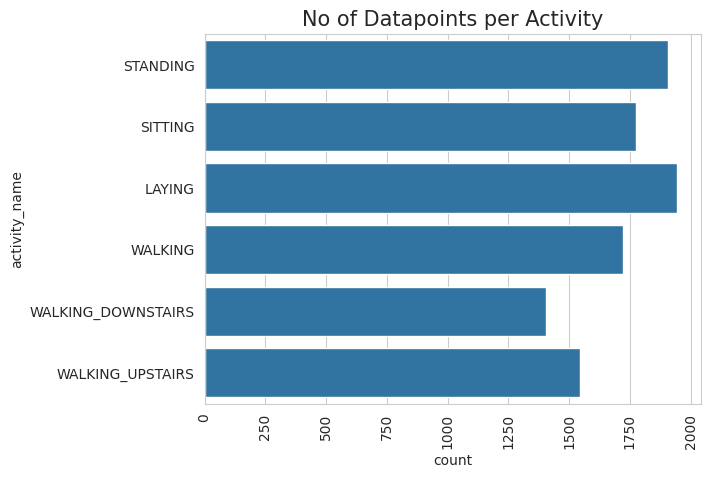

In [ ]:
plt.title('No of Datapoints per Activity', fontsize=15)
sns.countplot(data.activity_name)
plt.xticks(rotation=90)
plt.show()

From the visualization above, we can see an almost equal distribution of the activities with STANDING and LAYING having the highest representation.

The data provides insight into the most common activities of people as they move through their days or lives in general. A pie chart is also plotted below for additional insight.

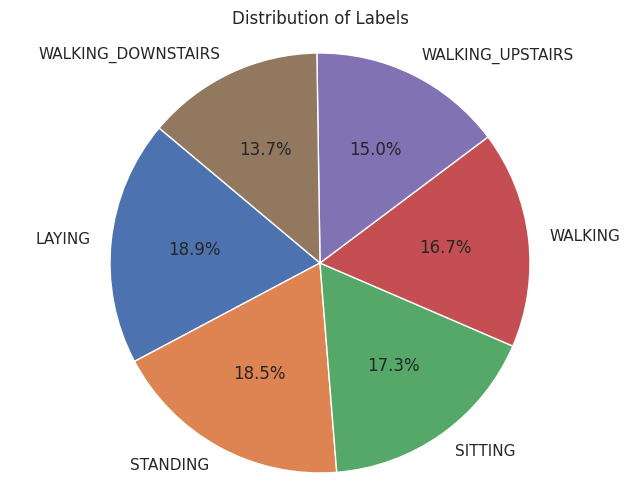

In [ ]:
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
plt.pie(data['activity_name'].value_counts(), labels=data['activity_name'].value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels')
plt.axis('equal')
plt.show()

Below, the dataset is also examined for balance with regards to the subjects used for the study. The resulting graph shows an approximately equal representation of activity data from all subjects in the study.

One insight to notice is the difference in the most represented activity from a subject. This can aid us in understanding where most of the time of the subject is being spent. However, details of such analysis are beyond the scope of this project.

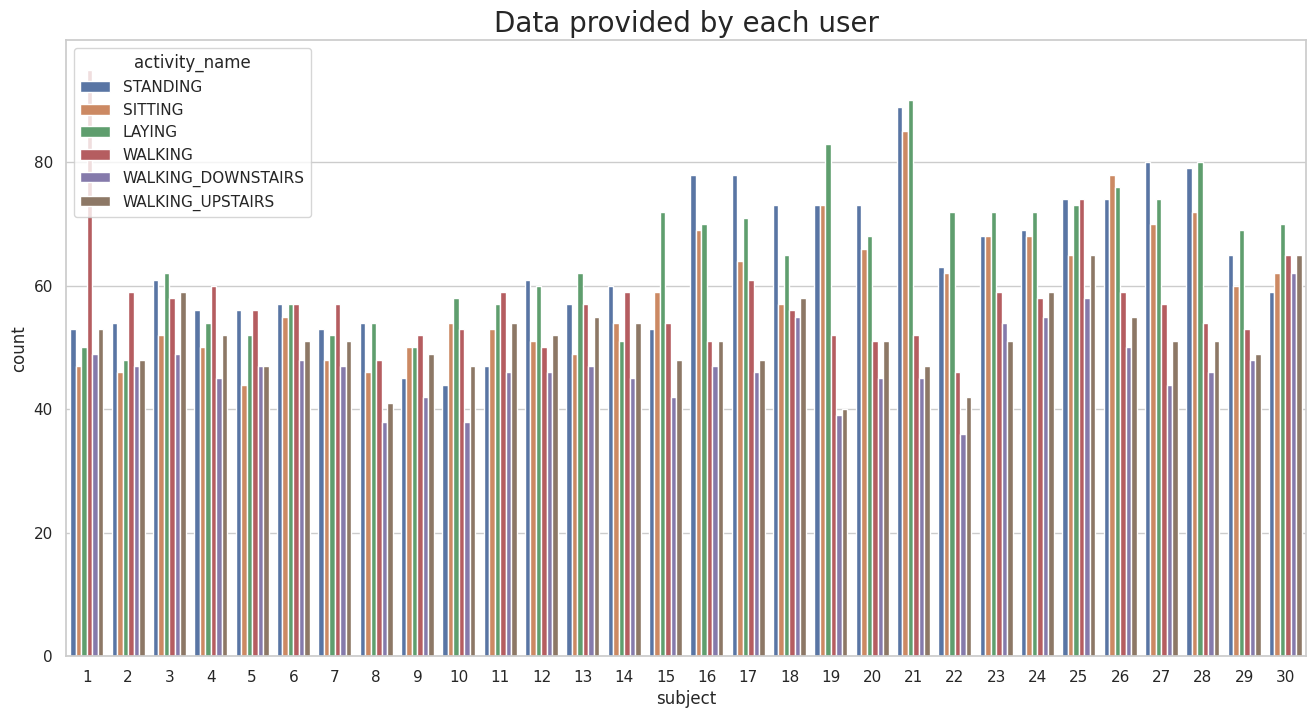

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Data provided by each user', fontsize=20)
sns.countplot(x='subject',hue='activity_name', data = data)
plt.show()

## Data processing

In [ ]:
print('We have {} NaN/Null values in train'.format(train_data.isnull().values.sum()))
print('We have {} NaN/Null values in test'.format(test_data.isnull().values.sum()))

We have 0 NaN/Null values in train
We have 0 NaN/Null values in test


In [ ]:
train_data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,activity
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515,17.413085,3.643362
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122,8.975143,1.744802
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414,8.000000,2.000000
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181,19.000000,4.000000
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659,26.000000,5.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000,30.000000,6.000000


In [ ]:
test_data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,activity
count,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,...,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000
mean,0.273996,-0.017863,-0.108386,-0.613635,-0.508330,-0.633797,-0.641278,-0.522676,-0.637038,-0.462063,...,-0.598756,0.005264,0.003799,0.040029,-0.017298,-0.513923,0.074886,-0.048720,12.986427,3.577876
std,0.060570,0.025745,0.042747,0.412597,0.494269,0.362699,0.385199,0.479899,0.357753,0.523916,...,0.311042,0.336147,0.445077,0.634989,0.501311,0.509205,0.324300,0.241467,6.950984,1.740348
min,-0.592004,-0.362884,-0.576184,-0.999606,-1.000000,-0.998955,-0.999417,-0.999914,-0.998899,-0.952357,...,-1.000000,-1.000000,-0.993402,-0.998898,-0.991096,-0.984195,-0.913704,-0.949228,2.000000,1.000000
25%,0.262075,-0.024961,-0.121162,-0.990914,-0.973664,-0.976122,-0.992333,-0.974131,-0.975352,-0.934447,...,-0.829593,-0.130541,-0.282600,-0.518924,-0.428375,-0.829722,0.022140,-0.098485,9.000000,2.000000
50%,0.277113,-0.016967,-0.108458,-0.931214,-0.790972,-0.827534,-0.937664,-0.799907,-0.817005,-0.852659,...,-0.683672,0.005188,0.006767,0.047113,-0.026726,-0.729648,0.181563,-0.010671,12.000000,4.000000
75%,0.288097,-0.010143,-0.097123,-0.267395,-0.105919,-0.311432,-0.321719,-0.133488,-0.322771,-0.009965,...,-0.458332,0.146200,0.288113,0.622151,0.394387,-0.545939,0.260252,0.092373,18.000000,5.000000
max,0.671887,0.246106,0.494114,0.465299,1.000000,0.489703,0.439657,1.000000,0.427958,0.786436,...,1.000000,0.998898,0.986347,1.000000,1.000000,0.833180,1.000000,0.973113,24.000000,6.000000


In [ ]:
train_data_activity = train_data[['activity', 'activity_name']]
train_data = train_data.drop(['subject','activity','activity_name'], axis=1)

In [ ]:
test_data_activity = test_data[['activity', 'activity_name']]
test_data = test_data.drop(['subject','activity','activity_name'], axis=1)

The data is scaled using the MinMax scaler before applying the clustering algorithms. The MinMaxScaler is a data preprocessing technique used to scale features to a specified range, typically between 0 and 1. It operates on each feature independently and computes the minimum and maximum values of each feature in the dataset.

In [ ]:
scaler = MinMaxScaler()

columns = train_data.columns

train_data = scaler.fit_transform(train_data)
train_data = pd.DataFrame(train_data, columns=columns)

test_data = scaler.fit_transform(test_data)
test_data = pd.DataFrame(test_data, columns=columns)

# Clustering / Modeling

In this section, we dive into the unsupervised learning clustering techniques as per the project description. Clustering is a type of unsupervised learning technique in machine learning where the goal is to partition a dataset into groups, or clusters, based on the similarity of data points within each cluster and dissimilarity between clusters. Unlike supervised learning, clustering algorithms do not require labeled data, meaning they work with unlabeled data where the true groupings or categories are unknown.

In this project, we focus on two clustering techniques namely:


1.   KMeans Clustering: KMeans clustering is an unsupervised machine learning algorithm used for partitioning a dataset into a predetermined number of clusters. The algorithm works by iteratively assigning each data point to the nearest cluster centroid and then updating the centroids based on the mean of the data points assigned to each cluster. This process continues until the centroids no longer change significantly or a predefined number of iterations is reached.
2.   DBSCAN Clustering: DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is also a clustering algorithm in machine learning designed to identify clusters of varying shapes and sizes in a dataset containing noise and outliers. Unlike traditional clustering algorithms like K-means, DBSCAN does not require specifying the number of clusters in advance. Instead, it groups together data points that are closely packed, forming dense regions separated by regions of lower density.


Two metrics are used to evaluate the performance of the clustring:

1.   Silhoutte Scores: The silhouette score is a metric used to evaluate the quality of clustering in unsupervised learning. It quantifies how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. A score close to 1 suggests dense, well-separated clusters, while a score near 0 indicates overlapping clusters. Conversely, a negative silhouette score implies that the object may have been assigned to the wrong cluster.
2.   Davies Bouldin Scores: The Davies-Bouldin Index (DBI) is a clustering evaluation metric that quantifies the compactness and separation of clusters in a dataset. It measures the average similarity between each cluster's centroid and the centroids of its nearest neighboring clusters, normalized by the sum of the intra-cluster distances. A lower DBI value indicates better clustering, with tight, well-separated clusters. The DBI offers a straightforward interpretation: the closer the value is to zero, the better the clustering performance.



In [ ]:
train_labels = train_data_activity['activity']
test_labels = test_data_activity['activity']

## Without Dimensionality Reduction

In the first step of the process, the clustering algorithms are applied on the dataset wihout using a dimensionality reduction technique. This is to understand the nature of the base clustering algorithms and find the optimal parameters for the methods.

In this stage, we use a RandomForestClassifier on the dataset (since it has ground truth), to understand the most important features in the dataset before visualizing our clustering. Due to the high dimensionality of the data, the selected features will aid in visualizing the data in a simple manner before applying dimensionality reduction techniques.

This step is only possible because the dataset already contains ground truth labels. In most scenarios of unsupervised learning, the dataset does not contain labels and this technique cannot be employed.

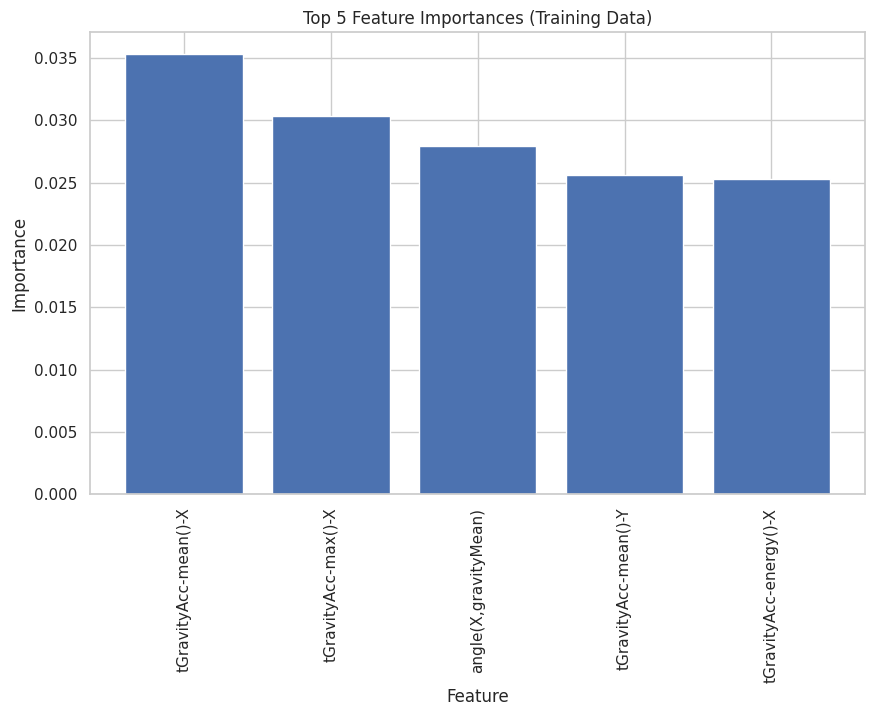

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42)

rf_classifier.fit(train_data, train_labels)

feature_importances_train = rf_classifier.feature_importances_

sorted_indices_train = feature_importances_train.argsort()[::-1]

top_n_features_train = train_data.columns[sorted_indices_train][:5]

plt.figure(figsize=(10, 6))
plt.bar(range(5), feature_importances_train[sorted_indices_train][:5], align="center")
plt.xticks(range(5), top_n_features_train, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Top {} Feature Importances (Training Data)".format(5))
plt.show()

In [ ]:
list(top_n_features_train)

['tGravityAcc-mean()-X',
 'tGravityAcc-max()-X',
 'angle(X,gravityMean)',
 'tGravityAcc-mean()-Y',
 'tGravityAcc-energy()-X']

### KMeans

A base KMeans model is first trained using domain knowledge of the dataset containing 6 labels. It is then fine-tuned using the Elbow method to find the optimal number of clusters.


In [ ]:
kmeans = KMeans(n_clusters=6, n_init='auto', random_state=42, algorithm='elkan')
kmeans.fit(train_data)
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_
inertia = kmeans.inertia_

print("Lowest SSE:", inertia)

Lowest SSE: 34266.500860186454


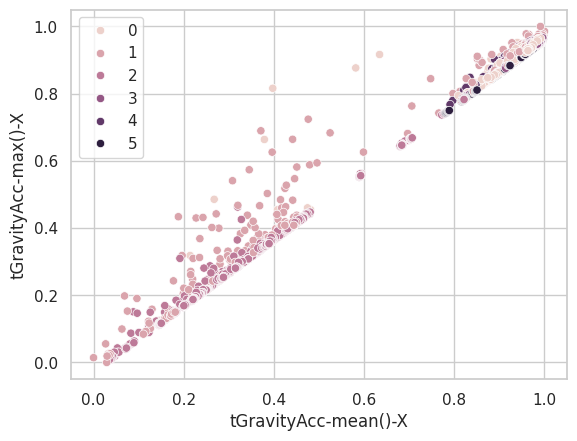

In [ ]:
sns.scatterplot(data=train_data, x="tGravityAcc-mean()-X", y="tGravityAcc-max()-X", hue=cluster_labels)
plt.show()

From the above graph, we can that a large number of the clusters overlap with one another. The number of clusters selected is not optimal.

Therefore, we proceed to using the elbow method and found out the optimal number of clusters is 2.

In [ ]:
kmeans_kwargs = {
     "init": "random",
     "n_init": 'auto',
     "max_iter": 300,
     "random_state": 42,
}

sse = []

for k in range(1, 7):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(train_data)
  sse.append(kmeans.inertia_)

In [ ]:
def plot_score(score_list, title, start_index, end_index):
  plt.style.use("fivethirtyeight")
  plt.plot(range(start_index, end_index), score_list)
  plt.xticks(range(start_index, end_index))
  plt.xlabel("Number of Clusters")
  plt.ylabel(title)
  plt.show()

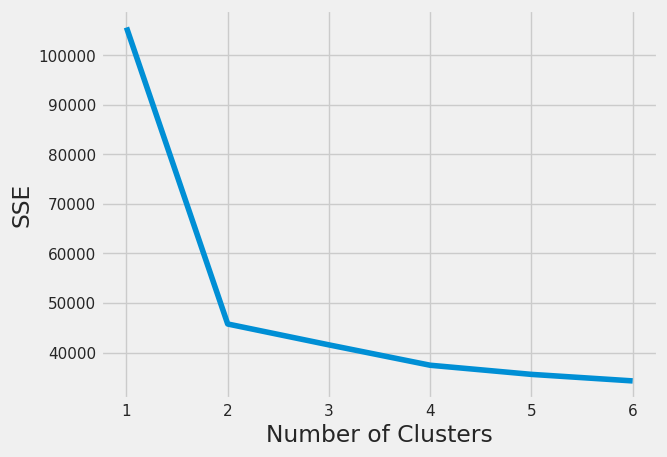

In [ ]:
plot_score(sse, "SSE", 1 , 7)

In [ ]:
silhouette_coefficients = []
davies_bouldin_scores = []

# Notice we start at 2 clusters for silhouette coefficient
for k in range(2, 7):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(train_data)
  score = silhouette_score(train_data, kmeans.labels_)
  davies_score = davies_bouldin_score(train_data, kmeans.labels_)
  normalized_info_score = normalized_mutual_info_score(train_labels, kmeans.labels_)
  silhouette_coefficients.append(score)
  davies_bouldin_scores.append(davies_score)

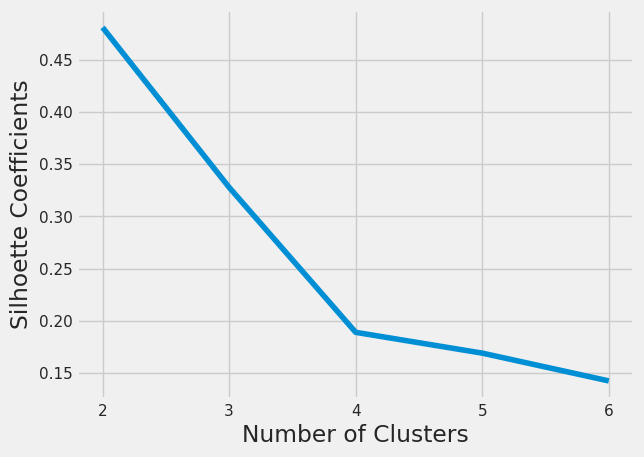

In [ ]:
plot_score(silhouette_coefficients, "Silhoette Coefficients", 2, 7)

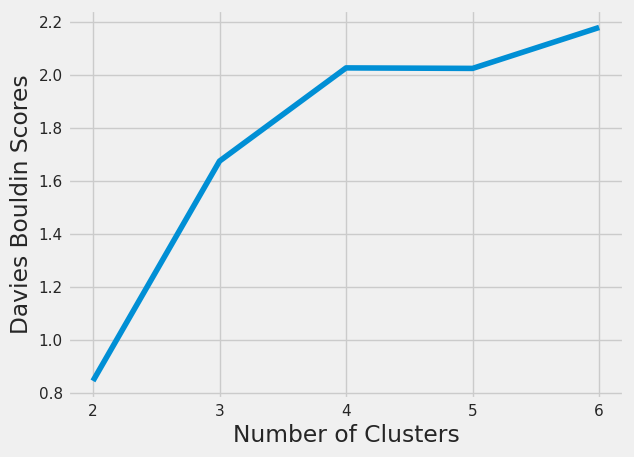

In [ ]:
plot_score(davies_bouldin_scores, "Davies Bouldin Scores", 2, 7)

After using the metrics to determine the optimal value of clusters as two, we proceed to fit the KMeans model using the information

In [ ]:
kmeans_optimal = KMeans(n_clusters=2, random_state=42)

start_time = time.time()
kmeans_optimal.fit(train_data)
end_time = time.time()
elapsed_time = end_time - start_time

cluster_centers_optimal = kmeans_optimal.cluster_centers_
cluster_labels_optimal = kmeans_optimal.labels_
print("Silhouette score:", silhouette_score(train_data, cluster_labels_optimal))
print("Davies Bouldin score:", davies_bouldin_score(train_data, cluster_labels_optimal))
print("Elapsed time:", elapsed_time, "seconds")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score: 0.4811022921538455
Davies Bouldin score: 0.8457163157647587
Elapsed time: 1.080798625946045 seconds


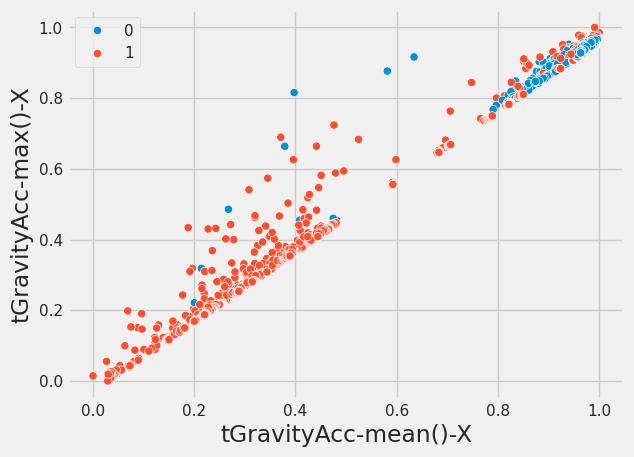

In [ ]:
sns.scatterplot(data=train_data, x="tGravityAcc-mean()-X", y="tGravityAcc-max()-X", hue=cluster_labels_optimal)
plt.show()

Using the features selected above, we can the data being split around the middle. However, there is still noise in the separation and using dimensionality reduction techniques for both clustering and visualization should improve the results.

The cluster is fitted on the test dataset below:

In [ ]:
test_cluster_labels = kmeans_optimal.predict(test_data)

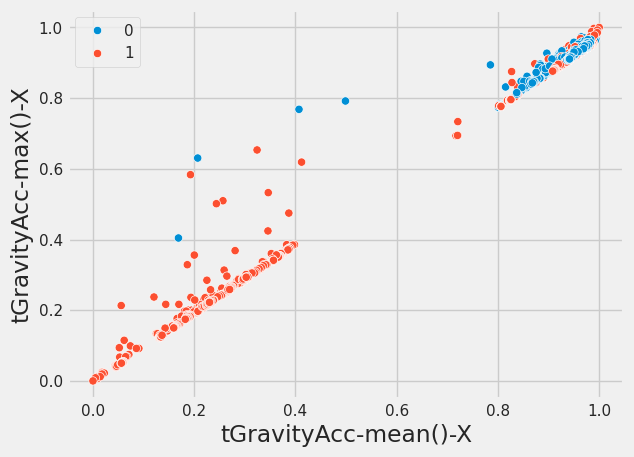

In [ ]:
sns.scatterplot(data=test_data, x="tGravityAcc-mean()-X", y="tGravityAcc-max()-X", hue=test_cluster_labels)
plt.show()

The PCA dimensionality reduction technique is then applied to plot the data. This reduces the highly dimensional data to a lower dimensional representation of two components to facilitate visualization

In [ ]:
pca = PCA(n_components=2)
train_data_pca = pca.fit_transform(train_data)
cluster_centers_optimal_pca = pca.transform(cluster_centers_optimal)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


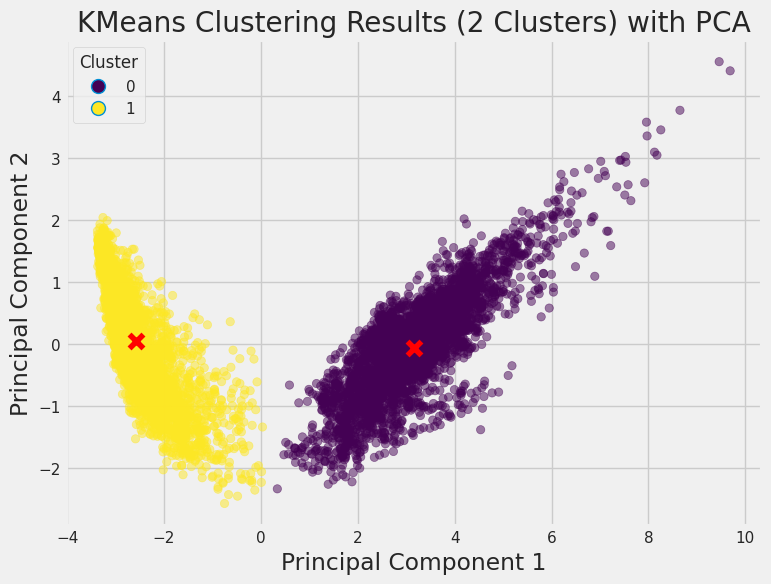

In [ ]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(train_data_pca[:, 0], train_data_pca[:, 1], c=cluster_labels_optimal, cmap='viridis', alpha=0.5)

plt.scatter(cluster_centers_optimal_pca[:, 0], cluster_centers_optimal_pca[:, 1], c='red', marker='x', s=100, label='Cluster Centers')

unique_labels = np.unique(cluster_labels_optimal)
colors = [scatter.to_rgba(label) for label in unique_labels]

custom_legend = [plt.Line2D([0], [0], linestyle="none", marker="o", markersize=10, markerfacecolor=color) for color in colors]
plt.legend(custom_legend, unique_labels, title='Cluster')

plt.title('KMeans Clustering Results (2 Clusters) with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

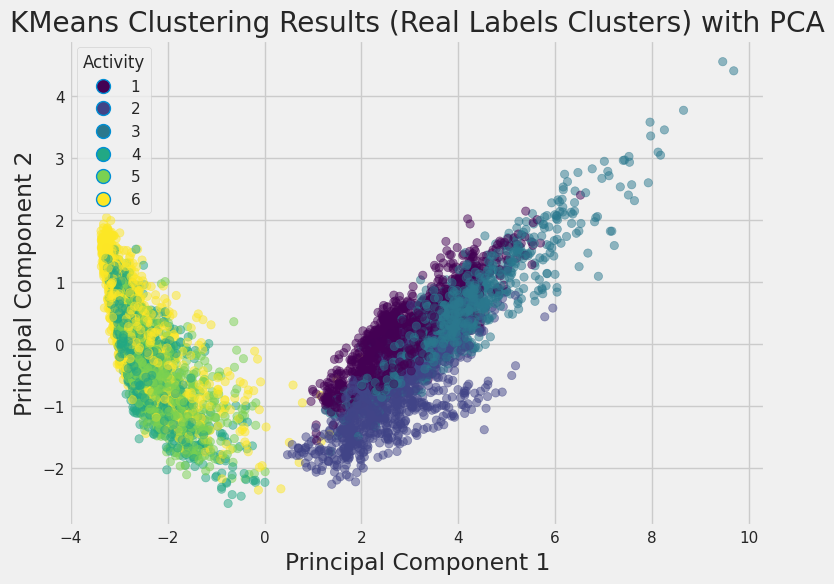

In [ ]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(train_data_pca[:, 0], train_data_pca[:, 1], c=train_labels, cmap='viridis', alpha=0.5)

unique_labels = np.unique(train_labels)
colors = [scatter.to_rgba(label) for label in unique_labels]

custom_legend = [plt.Line2D([0], [0], linestyle="none", marker="o", markersize=10, markerfacecolor=color) for color in colors]
plt.legend(custom_legend, unique_labels, title='Activity')

plt.title('KMeans Clustering Results (Real Labels Clusters) with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

In [ ]:
contingency_table = np.zeros((len(train_data), 2), dtype=int)

for i in range(len(train_data)):
    contingency_table[i,0] = train_labels[i]
    contingency_table[i,1] = cluster_labels_optimal[i]

c_table = pd.DataFrame(contingency_table, columns=['real_labels', 'clusters'])

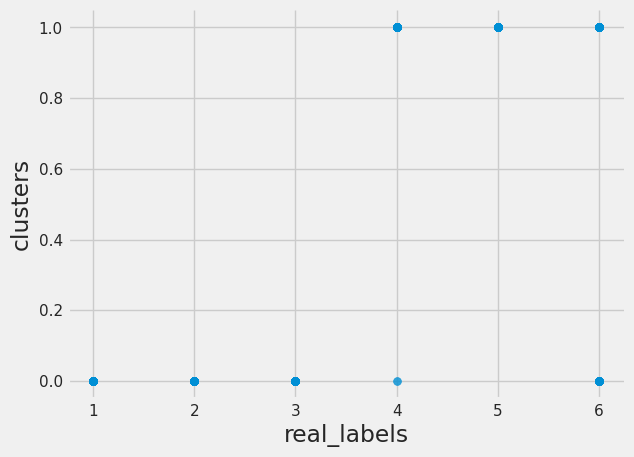

In [ ]:
c_table.plot(kind='scatter', x='real_labels', y='clusters', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
c_table.value_counts()

real_labels  clusters
6            1           1396
5            1           1374
4            1           1285
1            0           1226
2            0           1073
3            0            986
6            0             11
4            0              1
dtype: int64

Labels 1, 2 and 3 are grouped in the 0 cluster while labels 4, 5 and 6 are grouped in the 1 cluster as we can also see from the clustering diagrams.

From this we can conclude given the activities labels: [1', 'WALKING'], ['2', 'WALKING_UPSTAIRS'], ['3', 'WALKING_DOWNSTAIRS'] ['4', 'SITTING'], ['5', 'STANDING'], ['6', 'LAYING'], two clusters diffrentiate between ACTIVE and PASSIVE activities.

### DBSCAN

Unlike the KMeans clustering algorithm where the number of clusters is provided, DBSCAN finds the optimal number of clusters by itself. However, it uses two key hyperparameters to achieve this:



1.   Epsilon: This is the most important hyper-parameter of the DBSCAN algorithm. Epsilon defines the radius within which the algorithm searches for neighboring points around a core point. In other words, it determines the maximum distance between two points for them to be considered as part of the same neighborhood. Points within this radius are considered directly density-reachable from each other. Adjusting epsilon allows for the customization of the cluster density sensitivity: smaller values result in denser clusters, while larger values lead to more points being included in clusters, potentially merging neighboring clusters.
2.   Min Samples: This defines the minimum number of data points required to form a dense region or cluster. Specifically, it determines the density threshold necessary for a point to be considered a core point, which is fundamental to the DBSCAN algorithm. Adjusting the min_samples parameter impacts the granularity of the resulting clusters: higher values yield larger, more sparse clusters, while lower values produce smaller, denser clusters.



In [ ]:
data_activity = data[['activity', 'activity_name']]
data = data.drop(['subject','activity','activity_name'], axis=1)

The elbow method is employed using the NearestNeighbors algorithm to find the optimal value of the epsilon parameter.

In [ ]:
min_samples = 2 * num_features

In [ ]:
def plot_elbow_method(data, k):
    nearest_neighbors = NearestNeighbors(n_neighbors=k)
    nearest_neighbors_fit = nearest_neighbors.fit(data)
    distances, indices = nearest_neighbors_fit.kneighbors(data)

    distances = np.sort(distances, axis=0)
    distances = distances[:,1]

    kneedle = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
    optimal_epsilon_index = kneedle.elbow
    optimal_epsilon = distances[optimal_epsilon_index]

    print("Optimal Epsilon:", optimal_epsilon)

    kneedle.plot_knee()

Optimal Epsilon: 5.857742309000049


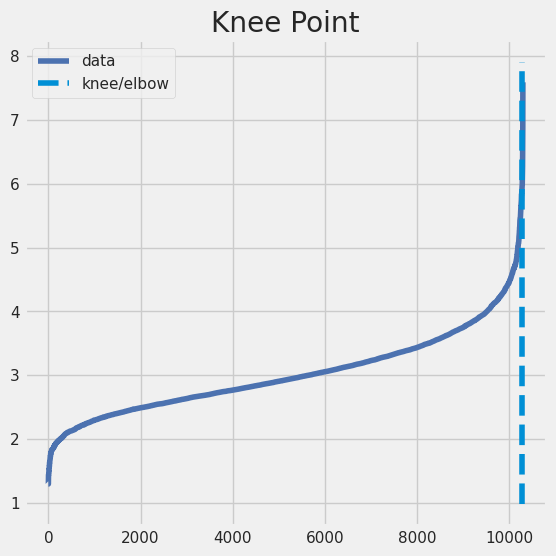

In [ ]:
plot_elbow_method(data, k=min_samples-1)

From the graph above, the optimal value of episilon is around 5.86 as this is the point with the maximum curvature in the graph.

Next we iteratively try this eplision value with different min-samples by measuring the Silhouette and Davies-Bouldin scores.

It is recommended in the scientific community to use a min_sample value atleast the value of the data's dimension.

In [ ]:
dimensionality = len(data.columns)

In [ ]:
epsilon = 5.86
min_samples = [dimensionality, (dimensionality + (dimensionality//2)), (dimensionality*2), ((dimensionality*2)+(dimensionality//2)), ((dimensionality*2)+(dimensionality))]

In [ ]:
db_silhouette_coefficients = []
db_davies_scores = []

for ms in min_samples:
  labels = DBSCAN(min_samples=ms, eps = epsilon).fit(data).labels_
  score = silhouette_score(data, labels)
  db_silhouette_coefficients.append(score)
  davies_score = davies_bouldin_score(data, labels)
  db_davies_scores.append(davies_score)

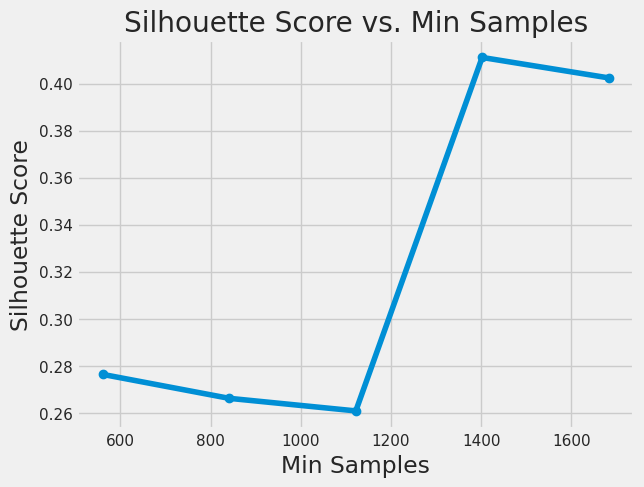

In [ ]:
plt.plot(min_samples, db_silhouette_coefficients, marker='o')
plt.xlabel('Min Samples')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Min Samples')
plt.grid(True)
plt.show()

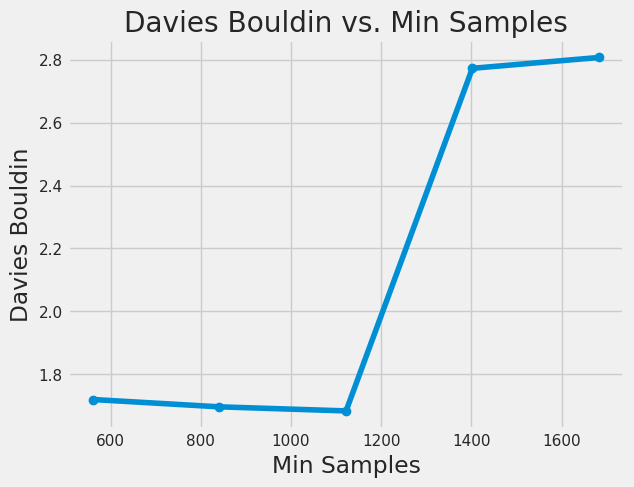

In [ ]:
plt.plot(min_samples, db_davies_scores, marker='o')
plt.xlabel('Min Samples')
plt.ylabel('Davies Bouldin')
plt.title('Davies Bouldin vs. Min Samples')
plt.grid(True)
plt.show()

In [ ]:
start_time = time.time()

dbscan_optimal = DBSCAN(eps=epsilon, min_samples=1300)
db_cluster_labels_optimal = dbscan_optimal.fit_predict(data)

end_time = time.time()
elapsed_time = end_time - start_time

print("Silhouette score:", silhouette_score(data, db_cluster_labels_optimal))
print("Davies Bouldin score:", davies_bouldin_score(data, db_cluster_labels_optimal))
print("Elapsed time:", elapsed_time, "seconds")

Silhouette score: 0.41276205172464075
Davies Bouldin score: 2.6270648814449724
Elapsed time: 9.620997667312622 seconds


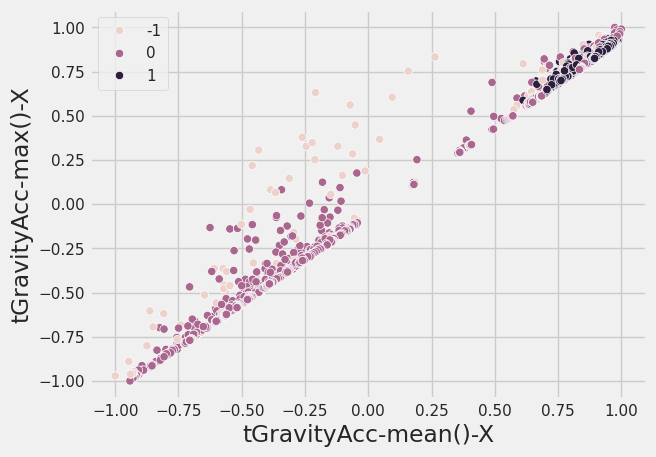

In [ ]:
sns.scatterplot(data=data, x="tGravityAcc-mean()-X", y="tGravityAcc-max()-X", hue=db_cluster_labels_optimal)
plt.show()

Like in the previous section with the KMeans algorithm, the high dimensionality of the data becomes challenging for the visualization process. The data is reduced to lower dimensions using PCA below and plotted

In [ ]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

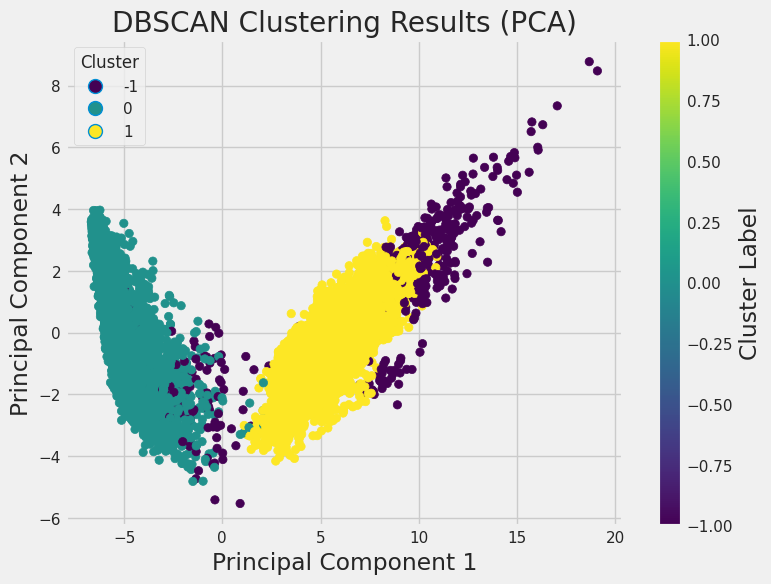

In [ ]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=db_cluster_labels_optimal, cmap='viridis')

unique_labels = np.unique(db_cluster_labels_optimal)
colors = [scatter.to_rgba(label) for label in unique_labels]

custom_legend = [plt.Line2D([0], [0], linestyle="none", marker="o", markersize=10, markerfacecolor=color) for color in colors]
plt.legend(custom_legend, unique_labels, title='Cluster')

plt.title('DBSCAN Clustering Results (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')

plt.show()

After using the elbow method to find the optimal epsilon value and using the Silhoutte and Davies Bouldin score to extrapolate the optimal min samples values, the DBSCAN algorithm classified the data into 3 clusters contrary to the 2 clusters provided by the KMeans algorithm.

From the diagram, we can see that DBSCAN separates the data into two clusters 0 and 1 with the noise cluster being identified as -1. This is due to DBSCAN's sensitivity to noise and it's algorithm assigning noises to a separate cluster.


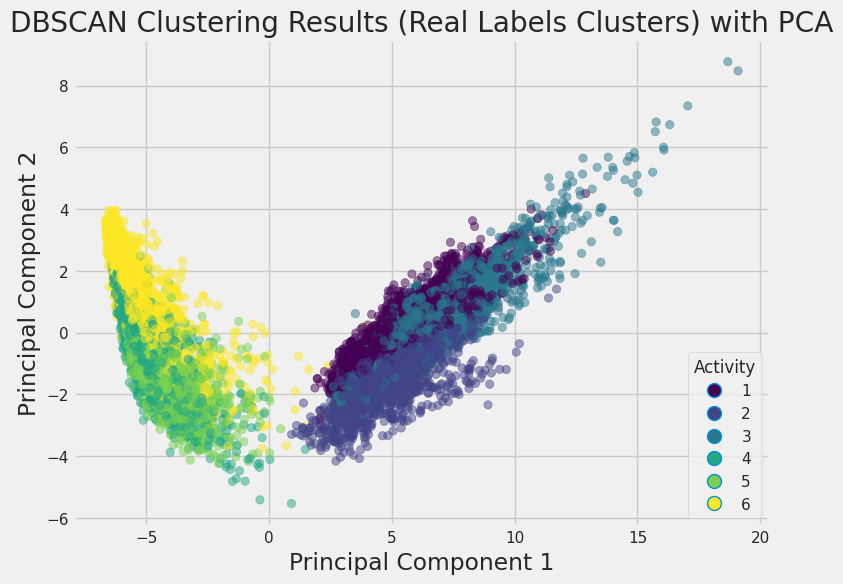

In [ ]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=data_activity['activity'], cmap='viridis', alpha=0.5)

unique_labels = np.unique(train_labels)
colors = [scatter.to_rgba(label) for label in unique_labels]

custom_legend = [plt.Line2D([0], [0], linestyle="none", marker="o", markersize=10, markerfacecolor=color) for color in colors]
plt.legend(custom_legend, unique_labels, title='Activity')

plt.title('DBSCAN Clustering Results (Real Labels Clusters) with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

Using dimensionality reduction below, we should notice improvement over our clustering as the data becomes represented in a lower-dimension allowing our clustering algorithms to capture the relationships better and more efficiently.

## With Dimensionality Reduction

As we've seen above, the data's high dimensionality introduces difficulties for the clustering algorithms. In terms of visualization, despite using RandomForest to choose the most important features to highlight the clustering performed, a dimensionality reduction technique PCA had to be employed to visualize the data in a presentable manner.

Dimensionality reduction is an important technique in data analysis and machine learning aimed at reducing the number of features or variables in a dataset while preserving its essential characteristics. It addresses the "curse of dimensionality" by simplifying high-dimensional data into a lower-dimensional space, making it more manageable, interpretable, and computationally efficient. Dimensionality reduction methods can broadly be categorized into two types: feature selection and feature extraction. In our project, we use feature extraction methods, that can create new features that are combinations of the original features, typically through techniques like Principal Component Analysis (PCA), Singular Value Decompositon (SVD) or LDA . These methods aim to capture the most relevant information in the data while reducing redundancy and noise.

The LDA with 3 components is selected for this project. Linear Discriminant Analysis (LDA) is a dimensionality reduction technique commonly used for clustering tasks. Unlike other methods such as PCA, LDA considers class information, aiming to find the feature subspace that maximizes class separability while minimizing intra-class variance. By projecting high-dimensional data onto a lower-dimensional space, LDA extracts discriminative features that facilitate clustering by grouping similar data points together. This reduction in dimensionality not only simplifies the clustering process but also enhances its effectiveness by preserving class-specific information, making LDA a valuable tool in various data clustering applications.

### KMeans with LDA

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=3)
train_data_lda = lda.fit_transform(train_data, train_labels)

In [ ]:
t_silhouette_coefficients = []
t_davies_bouldin_scores = []

# Notice we start at 2 clusters for silhouette coefficient
for k in range(2, 7):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(train_data_lda)
  score = silhouette_score(train_data_lda, kmeans.labels_)
  davies_score = davies_bouldin_score(train_data_lda, kmeans.labels_)
  t_silhouette_coefficients.append(score)
  t_davies_bouldin_scores.append(davies_score)

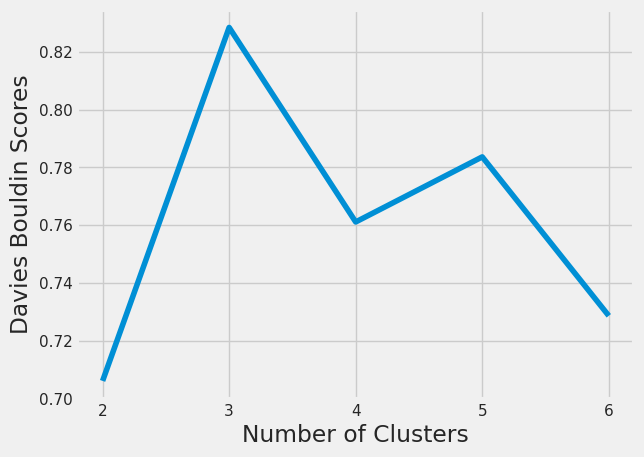

In [ ]:
plot_score(t_silhouette_coefficients, "Silhoutte Scores", 2, 7)

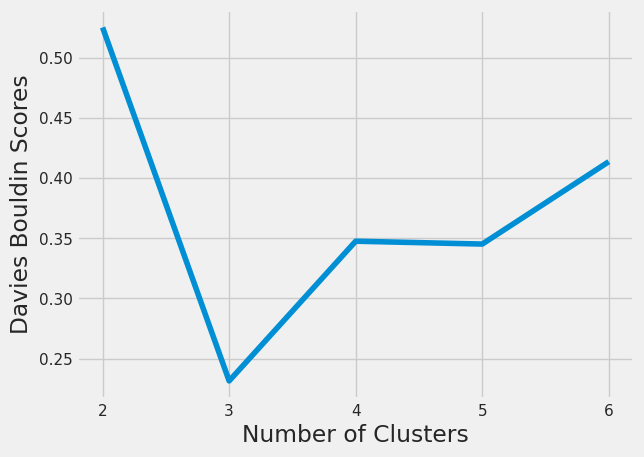

In [ ]:
plot_score(t_davies_bouldin_scores, "Davies Bouldin Scores", 2, 7)

In [ ]:
start_time = time.time()

kmeans_optimal_t = KMeans(n_clusters=3, random_state=42)
labels_t = kmeans_optimal_t.fit_predict(train_data_lda)

end_time = time.time()
elapsed_time = end_time - start_time

cluster_centers_optimal_t = kmeans_optimal_t.cluster_centers_
cluster_labels_optimal_t = kmeans_optimal_t.labels_

print("Silhouette score:", silhouette_score(train_data_lda, cluster_labels_optimal_t))
print("Davies Bouldin score:", davies_bouldin_score(train_data_lda, cluster_labels_optimal_t))
print("Elapsed time:", elapsed_time, "seconds")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score: 0.828402974285191
Davies Bouldin score: 0.23140206926995588
Elapsed time: 0.08568859100341797 seconds


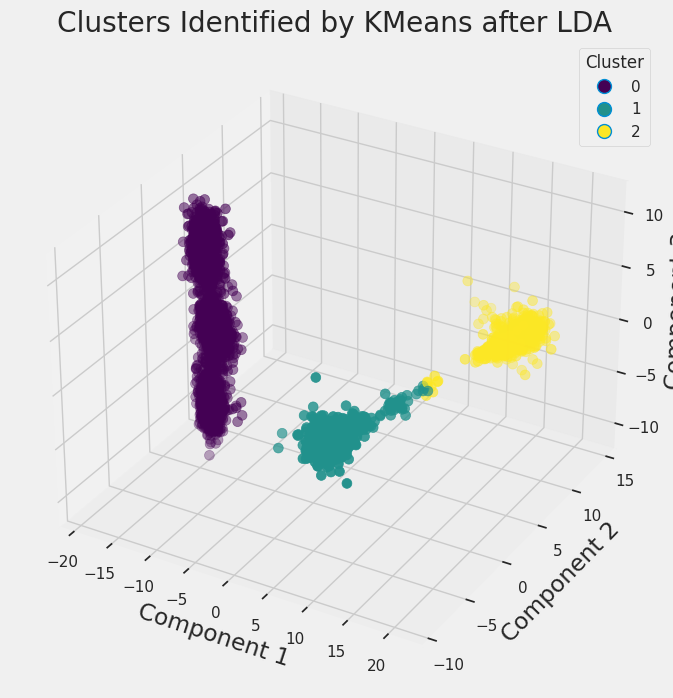

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(train_data_lda[:,0], train_data_lda[:,1], train_data_lda[:,2], c=labels_t, cmap='viridis', s=50)

unique_labels = np.unique(labels_t)
colors = [scatter.to_rgba(label) for label in unique_labels]

custom_legend = [plt.Line2D([0], [0], linestyle="none", marker="o", markersize=10, markerfacecolor=color) for color in colors]
ax.legend(custom_legend, unique_labels, title='Cluster', loc='upper right')

ax.set_title('Clusters Identified by KMeans after LDA')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.show()

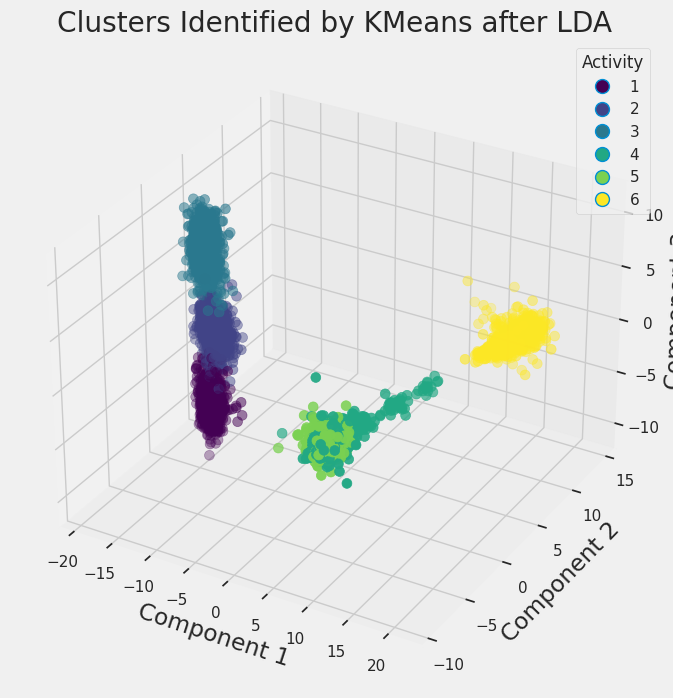

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(train_data_lda[:,0], train_data_lda[:,1], train_data_lda[:,2], c=train_data_activity['activity'], cmap='viridis', s=50)

unique_labels = np.unique(train_data_activity['activity'])
colors = [scatter.to_rgba(label) for label in unique_labels]

custom_legend = [plt.Line2D([0], [0], linestyle="none", marker="o", markersize=10, markerfacecolor=color) for color in colors]
ax.legend(custom_legend, unique_labels, title='Activity', loc='upper right')

ax.set_title('Clusters Identified by KMeans after LDA')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.show()

As seen from the diagrams above, applying dimensionality reduction facilitated the clustering process by providing the algorithm with much simpler features for consideration. Although the number of clusters increased to 3 in the KMeans method, the algorithm effectively segregates the data into three neat clusters.

Comparing the graph with the plot of the real labels as shown above, we can see that the alogrithm grouped the ACTIVE tasks of [1', 'WALKING'], ['2', 'WALKING_UPSTAIRS'], ['3', 'WALKING_DOWNSTAIRS'] into the 0 cluster and separated the PASSIVE tasks into two:  ['4', 'SITTING'], ['5', 'STANDING'] into cluster 1 and ['6', 'LAYING'] as a separate cluster 2. Despite labels 4, 5, and 6 being PASSIVE tasks, the algorithm could further diffrentiate between by considering the angles and position differences the two tasks entail.

### DBSCAN with LDA

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=3)
data_lda = lda.fit_transform(data, data_activity['activity'])

In [ ]:
min_samples = 2 * num_features

Optimal Epsilon: 1.7968693371153412


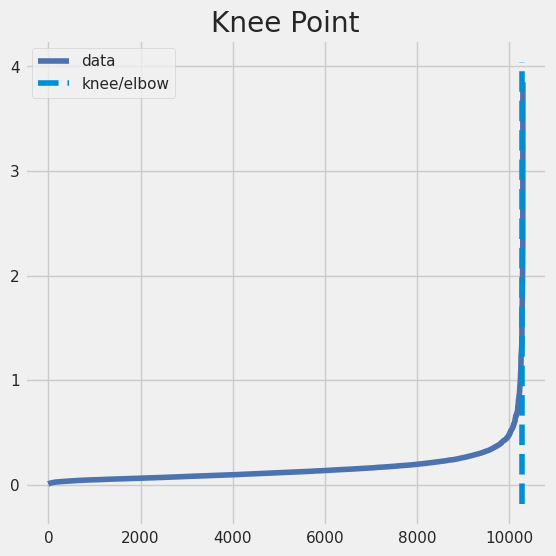

In [ ]:
plot_elbow_method(data_lda, k=min_samples-1)

In [ ]:
dimensionality = 3 # Number of components after dimensionality reduction

In [ ]:
epsilon = 1.79
min_samples = [dimensionality, (dimensionality + (dimensionality//2)), (dimensionality*2), ((dimensionality*2)+(dimensionality//2)), ((dimensionality*2)+(dimensionality))]

In [ ]:
db_silhouette_coefficients_lda = []
db_davies_scores_lda = []

for ms in min_samples:
  labels = DBSCAN(min_samples=ms, eps = epsilon).fit(data_lda).labels_
  score = silhouette_score(data_lda, labels)
  db_silhouette_coefficients_lda.append(score)
  davies_score = davies_bouldin_score(data_lda, labels)
  db_davies_scores_lda.append(davies_score)

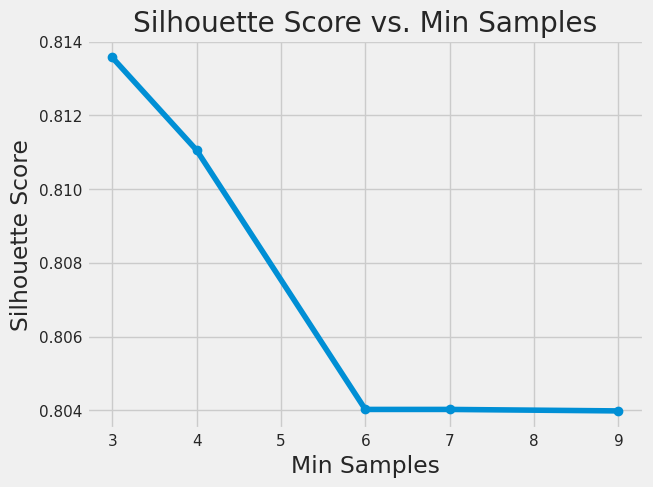

In [ ]:
plt.plot(min_samples, db_silhouette_coefficients_lda, marker='o')
plt.xlabel('Min Samples')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Min Samples')
plt.grid(True)
plt.show()

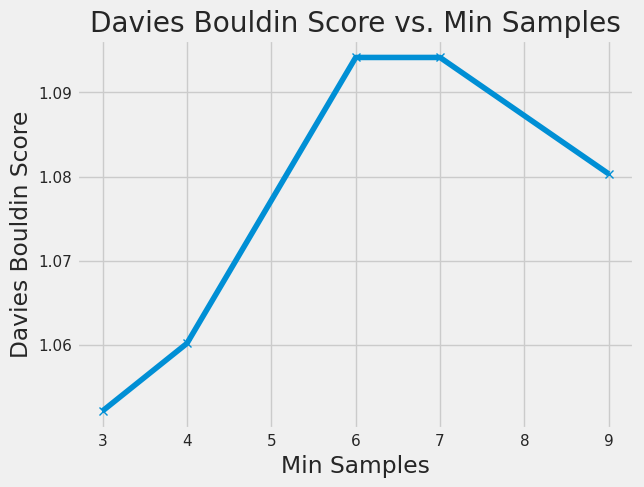

In [ ]:
plt.plot(min_samples, db_davies_scores_lda, marker='x')
plt.xlabel('Min Samples')
plt.ylabel('Davies Bouldin Score')
plt.title('Davies Bouldin Score vs. Min Samples')
plt.grid(True)
plt.show()

In [ ]:
start_time = time.time()

dbscan_lda = DBSCAN(eps=epsilon, min_samples=3)
db_cluster_labels_lda = dbscan_lda.fit_predict(data_lda)

end_time = time.time()
elapsed_time = end_time - start_time

print("Silhouette score:", silhouette_score(data_lda, db_cluster_labels_lda))
print("Davies Bouldin score:", davies_bouldin_score(data_lda, db_cluster_labels_lda))
print("Elapsed time:", elapsed_time, "seconds")

Silhouette score: 0.813568331247804
Davies Bouldin score: 1.0521508028650406
Elapsed time: 0.6280007362365723 seconds


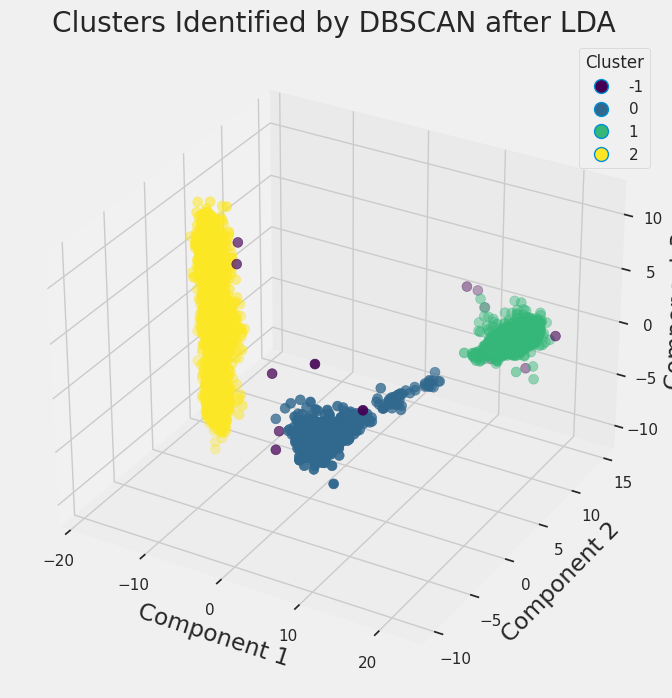

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data_lda[:,0], data_lda[:,1], data_lda[:,2], c=db_cluster_labels_lda, cmap='viridis', s=50)

unique_labels = np.unique(db_cluster_labels_lda)
colors = [scatter.to_rgba(label) for label in unique_labels]

custom_legend = [plt.Line2D([0], [0], linestyle="none", marker="o", markersize=10, markerfacecolor=color) for color in colors]
ax.legend(custom_legend, unique_labels, title='Cluster', loc='upper right')

ax.set_title('Clusters Identified by DBSCAN after LDA')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.show()

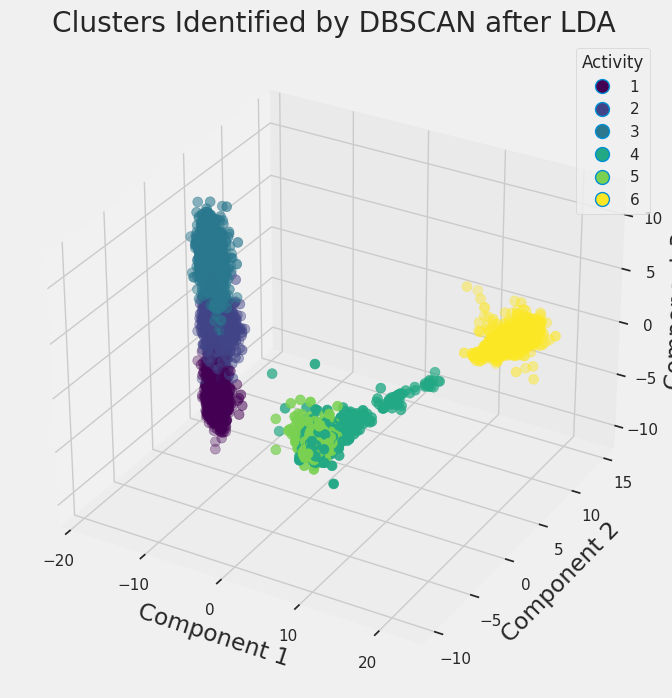

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data_lda[:,0], data_lda[:,1], data_lda[:,2], c=data_activity['activity'], cmap='viridis', s=50)

unique_labels = np.unique(data_activity['activity'])
colors = [scatter.to_rgba(label) for label in unique_labels]

custom_legend = [plt.Line2D([0], [0], linestyle="none", marker="o", markersize=10, markerfacecolor=color) for color in colors]
ax.legend(custom_legend, unique_labels, title='Activity', loc='upper right')

ax.set_title('Clusters Identified by DBSCAN after LDA')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.show()

Similar to the KMeans results, applying dimensionality reduction on the DBSCAN facilitated the creation of better and more informative clusters. One difference is the Noise cluster (label -1) present in the DBSCAN that represents data points considered outliers due to the DBSCAN's sensitivity to noise.

From the graphs above too with the plot of the real labels as shown above, we can see that the alogrithm grouped the ACTIVE tasks of [1', 'WALKING'], ['2', 'WALKING_UPSTAIRS'], ['3', 'WALKING_DOWNSTAIRS'] into the 0 cluster and separated the PASSIVE tasks into two:  ['4', 'SITTING'], ['5', 'STANDING'] into cluster 1 and ['6', 'LAYING'] as a separate cluster 2. Despite labels 4, 5, and 6 being PASSIVE tasks, the algorithm could further diffrentiate between by considering the angles and position differences the two tasks entail.

## Discussion

In the first iteration of the project, the KMeans and DBSCAN models were trained without employing dimensionality reduction. For the KMeans method, the elbow method together with the metrics used: Silhoutte score and Davies-Bouldin score, the optimal value of 2 clusters was found. The algorithm was able to effectively group the data points into two representative clusters. However, the complexity of the data made visualization tedious despite employing a feature selection algorithm to select the most pertinent features of the dataset. The PCA dimensionality reduction technique had to be employed to visualize the data in a more presentable manner.

Similarly, the elbow method was used for the DBSCAN to find the optimal epsilon value. Then using the domain knowledge, trail and error, and possible min-value parameters, the model was fit on the data and clusters were formed. DBSCAN sensitivity to noise and the data's high dimensionality made clustering challenging and the resulting visualization as well.

In the second part, the LDA dimensionality reduction technique was applied on the data before clustering. This simplified the highly dimensional data into 3 components facilitating the subsequent fitting of clustering models. The results showed better metric performance, clustering results and more informative/representative clustering visualizations.

In conclusion, from this project, we can deduce the importance of carefully choosing hyperparameters for the complex task of unsupervised learning and the importance of dimensionality reduction techniquess especially for high dimensional data in easing the clustering and visualization processes.